[0.9539392  1.85202592 1.28452326]
[1.  0.1 0.5]
1.7814034221247232


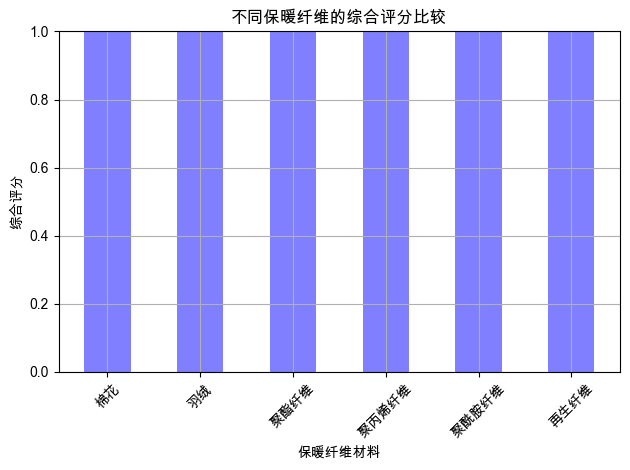

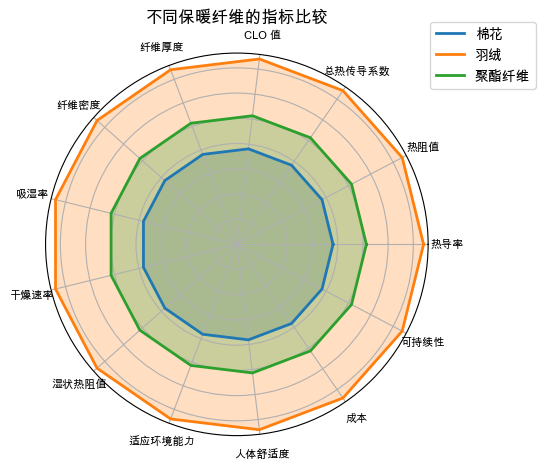

In [15]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial Unicode MS'  # Or any other font that supports CJK characters
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from math import sqrt

# 材料列表
materials = ['棉花', '羽绒', '聚酯纤维', '聚丙烯纤维', '聚酰胺纤维', '再生纤维']

# 原始数据
data = np.array([
    [0.1,0.2,0.3,0.4,0.5,0.6],
    [0.7,0.8,0.9,0.8,0.7,0.6],
    [0.1,0.3,0.5,0.7,0.9,0.0]
])

# 归一化指标数据
data_norm = np.linalg.norm(data, axis=1)
print(data_norm)

# 比较不同保暖纤维的综合评分
weights = np.array([1, 0.1, 0.5])  # 权重
print(weights)
scores = weights.dot(data_norm)
print	(scores)

# 绘制柱状图比较
plt.figure()
plt.bar(materials, scores, width=0.5, color='blue', alpha=0.5)
plt.xlabel('保暖纤维材料')
plt.ylabel('综合评分')
plt.title('不同保暖纤维的综合评分比较')
plt.ylim(0, 1)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig('fiber_comparison_bar.png')

# 绘制雷达图比较
spider_chart_data = np.tile(data_norm.reshape(-1, 1), (1, 14))  # 将首尾连接以闭合图形

spider_chart_labels =  ['热导率', '热阻值', '总热传导系数', 'CLO 值', '纤维厚度', '纤维密度',
                        '吸湿率', '干燥速率', '湿状热阻值', '适应环境能力', '人体舒适度', '成本', '可持续性']

angles = np.linspace(0, 2 * np.pi, len(spider_chart_labels), endpoint=False).tolist()
angles += angles[:1]

plt.figure()
ax = plt.subplot(111, polar=True)
for i in range(len(spider_chart_data)):
    ax.plot(angles, spider_chart_data[i], linewidth=2, linestyle='solid', label=materials[i])
ax.fill(angles, spider_chart_data.T, alpha=0.25)

ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(spider_chart_labels, fontsize=8)
ax.yaxis.grid(True)

plt.title('不同保暖纤维的指标比较')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
# plt.savefig('fiber_comparison_radar.png')
plt.show()


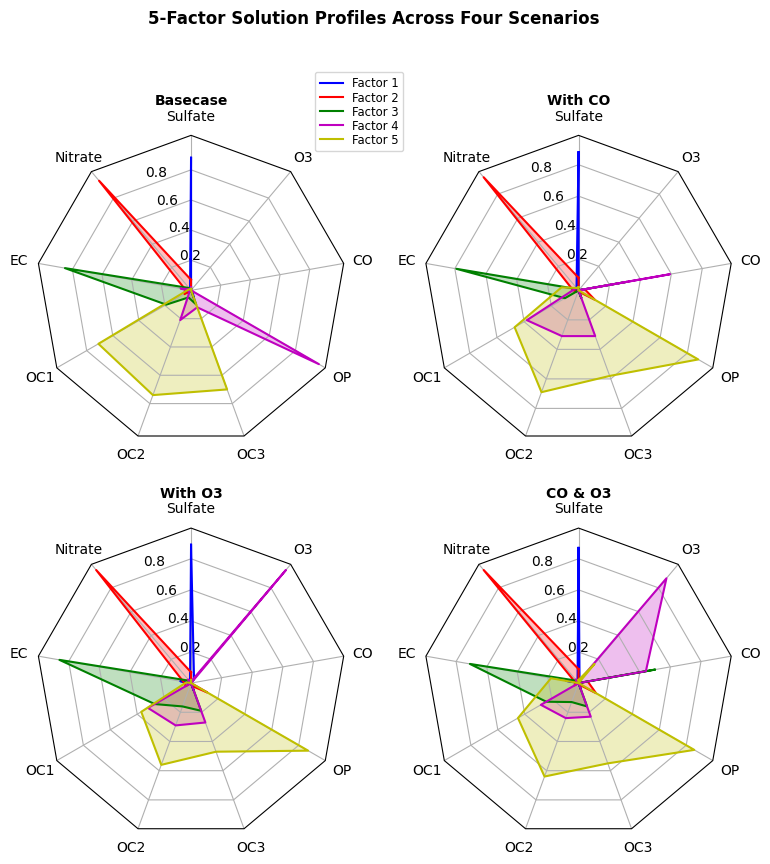

In [3]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


def example_data():
    # The following data is from the Denver Aerosol Sources and Health study.
    # See doi:10.1016/j.atmosenv.2008.12.017
    #
    # The data are pollution source profile estimates for five modeled
    # pollution sources (e.g., cars, wood-burning, etc) that emit 7-9 chemical
    # species. The radar charts are experimented with here to see if we can
    # nicely visualize how the modeled source profiles change across four
    # scenarios:
    #  1) No gas-phase species present, just seven particulate counts on
    #     Sulfate
    #     Nitrate
    #     Elemental Carbon (EC)
    #     Organic Carbon fraction 1 (OC)
    #     Organic Carbon fraction 2 (OC2)
    #     Organic Carbon fraction 3 (OC3)
    #     Pyrolyzed Organic Carbon (OP)
    #  2)Inclusion of gas-phase specie carbon monoxide (CO)
    #  3)Inclusion of gas-phase specie ozone (O3).
    #  4)Inclusion of both gas-phase species is present...
    data = [
        ['Sulfate', 'Nitrate', 'EC', 'OC1', 'OC2', 'OC3', 'OP', 'CO', 'O3'],
        ('Basecase', [
            [0.88, 0.01, 0.03, 0.03, 0.00, 0.06, 0.01, 0.00, 0.00],
            [0.07, 0.95, 0.04, 0.05, 0.00, 0.02, 0.01, 0.00, 0.00],
            [0.01, 0.02, 0.85, 0.19, 0.05, 0.10, 0.00, 0.00, 0.00],
            [0.02, 0.01, 0.07, 0.01, 0.21, 0.12, 0.98, 0.00, 0.00],
            [0.01, 0.01, 0.02, 0.71, 0.74, 0.70, 0.00, 0.00, 0.00]]),
        ('With CO', [
            [0.88, 0.02, 0.02, 0.02, 0.00, 0.05, 0.00, 0.05, 0.00],
            [0.08, 0.94, 0.04, 0.02, 0.00, 0.01, 0.12, 0.04, 0.00],
            [0.01, 0.01, 0.79, 0.10, 0.00, 0.05, 0.00, 0.31, 0.00],
            [0.00, 0.02, 0.03, 0.38, 0.31, 0.31, 0.00, 0.59, 0.00],
            [0.02, 0.02, 0.11, 0.47, 0.69, 0.58, 0.88, 0.00, 0.00]]),
        ('With O3', [
            [0.89, 0.01, 0.07, 0.00, 0.00, 0.05, 0.00, 0.00, 0.03],
            [0.07, 0.95, 0.05, 0.04, 0.00, 0.02, 0.12, 0.00, 0.00],
            [0.01, 0.02, 0.86, 0.27, 0.16, 0.19, 0.00, 0.00, 0.00],
            [0.01, 0.03, 0.00, 0.32, 0.29, 0.27, 0.00, 0.00, 0.95],
            [0.02, 0.00, 0.03, 0.37, 0.56, 0.47, 0.87, 0.00, 0.00]]),
        ('CO & O3', [
            [0.87, 0.01, 0.08, 0.00, 0.00, 0.04, 0.00, 0.00, 0.01],
            [0.09, 0.95, 0.02, 0.03, 0.00, 0.01, 0.13, 0.06, 0.00],
            [0.01, 0.02, 0.71, 0.24, 0.13, 0.16, 0.00, 0.50, 0.00],
            [0.01, 0.03, 0.00, 0.28, 0.24, 0.23, 0.00, 0.44, 0.88],
            [0.02, 0.00, 0.18, 0.45, 0.64, 0.55, 0.86, 0.00, 0.16]])
    ]
    return data


if __name__ == '__main__':
    N = 9
    theta = radar_factory(N, frame='polygon')

    data = example_data()
    spoke_labels = data.pop(0)

    fig, axs = plt.subplots(figsize=(9, 9), nrows=2, ncols=2,
                            subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

    colors = ['b', 'r', 'g', 'm', 'y']
    # Plot the four cases from the example data on separate axes
    for ax, (title, case_data) in zip(axs.flat, data):
        ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
        ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                     horizontalalignment='center', verticalalignment='center')
        for d, color in zip(case_data, colors):
            ax.plot(theta, d, color=color)
            ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
        ax.set_varlabels(spoke_labels)

    # add legend relative to top-left plot
    labels = ('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5')
    legend = axs[0, 0].legend(labels, loc=(0.9, .95),
                              labelspacing=0.1, fontsize='small')

    fig.text(0.5, 0.965, '5-Factor Solution Profiles Across Four Scenarios',
             horizontalalignment='center', color='black', weight='bold',
             size='large')

    plt.show()

In [1]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial Unicode MS'  # Or any other font that supports CJK characters
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np

# 定义数据
data = [
        [1.37, 0.071, 0.71, 0.47, 0.15, 1.54, 7, 7, 9, 5, 8, 7, 8],
        [1.82, 0.052, 0.52, 0.34, 0.25, 1.31, 8, 6, 8, 8, 7, 6, 7],
        [2.97, 0.209, 0.21, 1.35, 0.15, 1.14, 3, 4, 4, 3, 3, 3, 4],
        [11.9, 0.084, 0.084, 0.54, 0.15, 1.38, 2, 3, 3, 2, 2, 2, 3],
        [19.6, 0.051, 0.051, 0.33, 0.15, 1.18, 1, 2, 2, 1, 1, 1, 2],
        [31.3, 0.032, 0.032, 0.032, 0.25, 1.31, 5, 6, 6, 7, 5, 4, 6],
        [18.2, 0.05, 0.05, 0.34, 0.15, 1.34, 6, 5, 7, 6, 6, 5, 6]
]
spoke_labels = ['热阻值','热导率', '热传导系数', 'CLO 值', '纤维厚度', '纤维密度',
              '填充方式（10）', '压缩程度（10）', '透湿性（10）','透风性（10）', 
              '温度适应性（10）', '风速适应性（10）', '人体感知（10）']
# theta = np.linspace(0, 2 * np.pi, len(spoke_labels), endpoint=False)

# # 创建雷达图
# fig, ax = plt.subplots(subplot_kw=dict(polar=True))

# # 绘制数据
# for d in data:
#     ax.plot(theta, d)
#     ax.fill(theta, d, alpha=0.25)

# # 设置标题
# ax.set_title( '不同保暖纤维的综合评分比较', weight='bold', size='17', position=(0.5, 1.15),
#               horizontalalignment='center', verticalalignment='center')

# # 设置标签
# ax.set_xticklabels(spoke_labels)

# plt.show()


ValueError: x and y must have same first dimension, but have shapes (14,) and (13,)

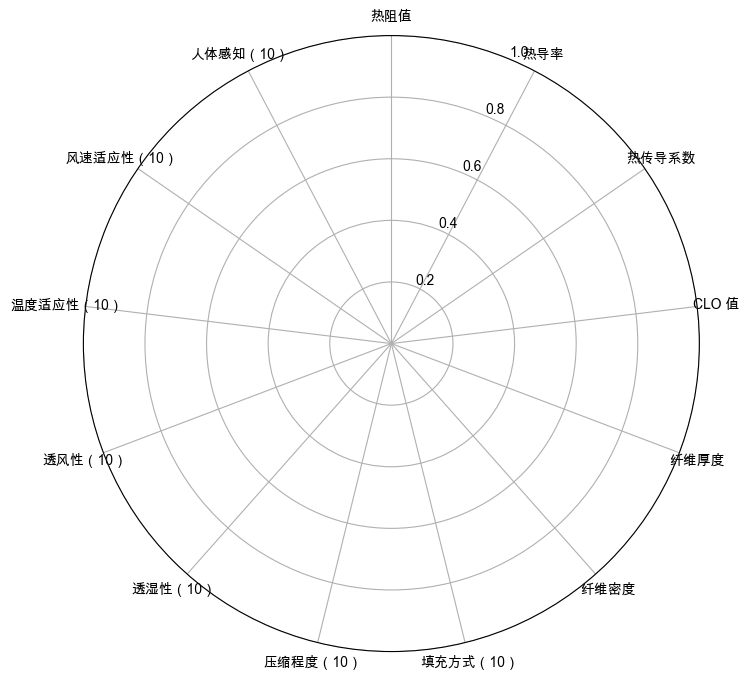

In [12]:

# 创建一个雷达图的极坐标系
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# 绘制雷达图的轴和标签
theta = np.linspace(0, 2 * np.pi, len(spoke_labels), endpoint=False).tolist()
theta += theta[:1]
# print(len(theta))
# for d in data:
#   print(len(d))
#   print(d)
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks(theta[:-1])
ax.set_xticklabels(spoke_labels)

# 绘制雷达图的轴和标签
# num_vars = len(spoke_labels)
# theta = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
# theta += theta[:1]
# ax.set_theta_offset(np.pi / 2)
# ax.set_theta_direction(-1)
# ax.set_xticks(theta[:-1])
# ax.set_xticklabels(spoke_labels)


# 绘制数据点，并用填充表示数据区域
for d in data:
    ax.plot(theta, d)
    ax.fill(theta, d, alpha=0.25)

# 设置图形标题
ax.set_title( '不同保暖纤维的综合评分比较', weight='bold', size='medium', position=(0.5, 1.1),
              horizontalalignment='center', verticalalignment='center')

# 显示雷达图
plt.show()

ValueError: x and y must have same first dimension, but have shapes (9,) and (1, 9)

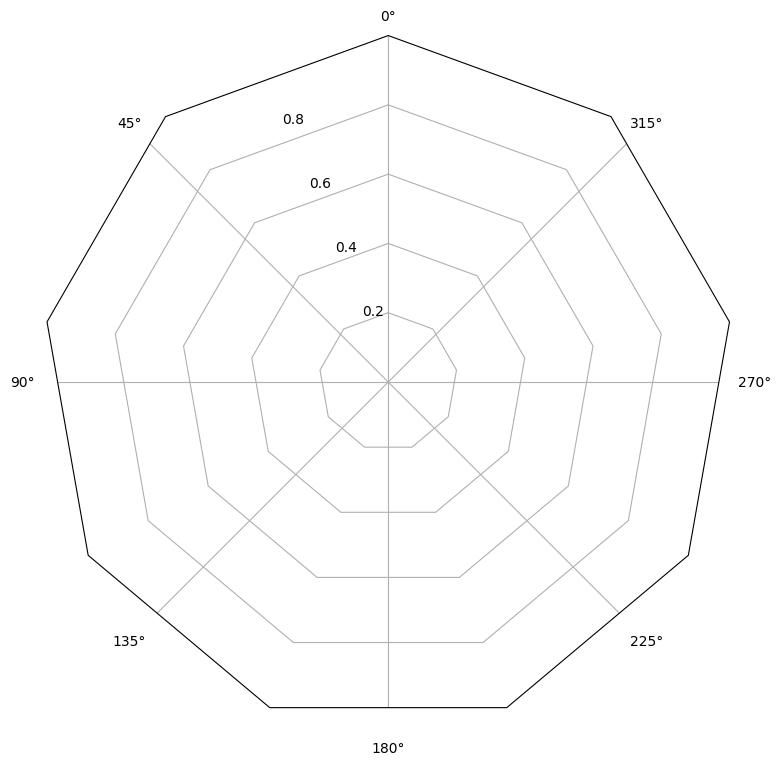

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(plt.PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(plt.PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


def example_data():
    data = [
        ['Sulfate', 'Nitrate', 'EC', 'OC1', 'OC2', 'OC3', 'OP', 'CO', 'O3'],
        ('Basecase', [
            [0.88, 0.01, 0.03, 0.03, 0.00, 0.06, 0.01, 0.00, 0.00]
        ])
    ]
    return data

if __name__ == '__main__':
    N = 9
    theta = radar_factory(N, frame='polygon')

    data = example_data()
    spoke_labels = data[0]
    case_data = data[1][1]

    fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=dict(projection='radar'))
    ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
    ax.plot(theta, case_data, color='b')
    ax.fill(theta, case_data, facecolor='b', alpha=0.25)
    ax.set_varlabels(spoke_labels)
    ax.set_title('Basecase', weight='bold', size='medium', position=(0.5, 1.1),
                 horizontalalignment='center', verticalalignment='center')

    plt.show()


# 相关性分析和多元性回归

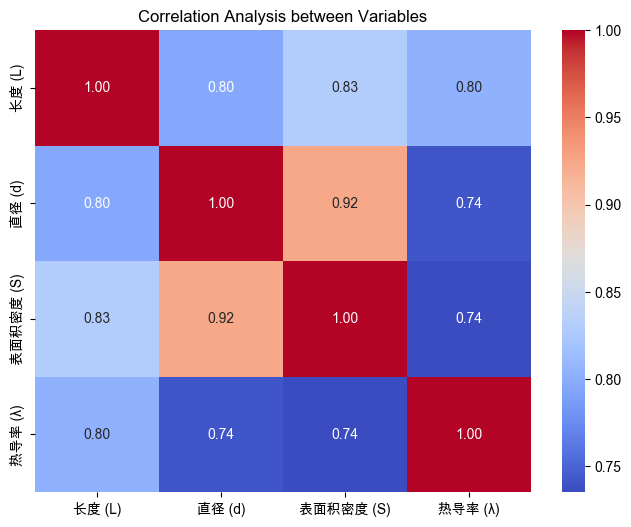

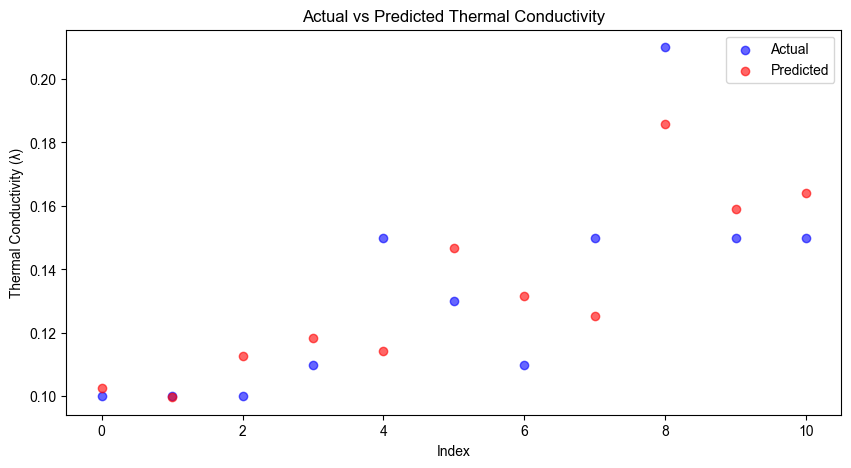

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                热导率 (λ)   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.533
Method:                 Least Squares   F-statistic:                     4.807
Date:                Sun, 14 Apr 2024   Prob (F-statistic):             0.0401
Time:                        18:47:17   Log-Likelihood:                 28.330
No. Observations:                  11   AIC:                            -48.66
Df Residuals:                       7   BIC:                            -47.07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0899      0.017      5.442      0.001       0.051       0.129
长度 (L)         0.0010      0.001      1.510      0.175      -0.001       0.003
直径 (d)         0.0002      0.000      0.540      0.606      -0.001       0.001
表面积密度 (S)     -0.0338      0.530     -0.064      0.951      -1.288       1.221
==============================================================================
Omnibus:                        2.108   Durbin-Watson:                   2.190
Prob(Omnibus):                  0.349   Jarque-Bera (JB):                1.473
Skew:                           0.788   Prob(JB):                        0.479
Kurtosis:                       2.147   Cond. No.                     6.33e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.33e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [16]:
import numpy as np
from numpy.linalg import inv

# 定义多元线性回归模型
def multiple_linear_regression(X, y):
    X = np.column_stack((np.ones(len(X)), X))  # 添加常数项
    beta = np.dot(inv(np.dot(X.T, X)), np.dot(X.T, y))  # 最小二乘法估计
    y_hat = np.dot(X, beta)  # 因变量拟合值
    residuals = y - y_hat  # 残差
    SSE = np.dot(residuals, residuals)  # 残差平方和
    SST = np.dot((y - np.mean(y)), (y - np.mean(y)))  # 总平方和
    R_squared = 1 - (SSE / SST)  # 拟合优度
    return beta, y_hat, residuals, R_squared

# 示例数据
X = np.array([[1, 2], [2, 3], [3, 4], [4, 5], [5, 6]])
y = np.array([5, 7, 9, 11, 13])

# 计算多元线性回归模型参数
beta, y_hat, residuals, R_squared = multiple_linear_regression(X, y)

# 输出结果
print("回归系数 beta：", beta)
print("因变量拟合值 y_hat：", y_hat)
print("残差 residuals：", residuals)
print("拟合优度 R_squared：", R_squared)


LinAlgError: Singular matrix

In [17]:
import numpy as np
import statsmodels.api as sm

# 添加截距列
X = sm.add_constant(data)		# 特征的数据集X和对应的目标变量y

# 构建模型
model = sm.OLS(y, X)		

# 使用最小二乘法拟合模型
results = model.fit()

# 输出模型摘要信息
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.320e+30
Date:                Mon, 15 Apr 2024   Prob (F-statistic):           5.54e-16
Time:                        04:30:29   Log-Likelihood:                 93.477
No. Observations:                   3   AIC:                            -183.0
Df Residuals:                       1   BIC:                            -184.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1111   5.38e-15   2.06e+14      0.0

/Users/chenxin/anaconda3/envs/Tianluo/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/chenxin/anaconda3/envs/Tianluo/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/chenxin/anaconda3/envs/Tianluo/lib/python3.11/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [18]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# 示例数据
data = {
    '保暖能力': [90, 92, 88, 85, 95, 87, 91, 93, 89, 94],
    '纤维平均长度': [2.5, 3.0, 2.7, 2.3, 3.2, 2.6, 2.9, 3.1, 2.8, 3.3],
    '纤维直径': [0.5, 0.6, 0.4, 0.7, 0.6, 0.5, 0.4, 0.6, 0.5, 0.7]
}

# 创建DataFrame
df = pd.DataFrame(data)

# 添加常数项
df['常数项'] = 1

# 定义自变量和因变量
X = df[['纤维平均长度', '纤维直径', '常数项']]
y = df['保暖能力']

# 利用最小二乘法进行多元线性回归
model = sm.OLS(y, X).fit()

# 输出回归结果
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                   保暖能力   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     20.56
Date:                Mon, 15 Apr 2024   Prob (F-statistic):            0.00117
Time:                        04:42:02   Log-Likelihood:                -15.668
No. Observations:                  10   AIC:                             37.34
Df Residuals:                       7   BIC:                             38.24
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
纤维平均长度         9.2021      1.479      6.220      0.0

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (10,) and arg 2 with shape (11,).

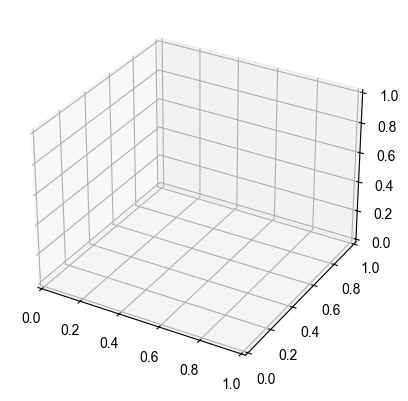

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

data = {
    '保暖能力': [90, 92, 88, 85, 95, 87, 91, 93, 89, 94],
    '纤维平均长度': [2.5, 3.0, 2.7, 2.3, 3.2, 2.6, 2.9, 3.1, 2.8, 3.3],
    '纤维直径': [0.5, 0.6, 0.4, 0.7, 0.6, 0.5, 0.4, 0.6, 0.5, 0.7]
}

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 提取数据
x = data['纤维平均长度']
y = data['纤维直径']
z = data['保暖能力']

# 绘制三维散点图
ax.scatter(x, y, z, c='r', marker='o')

# 设置坐标轴标签
ax.set_xlabel('纤维平均长度')
ax.set_ylabel('纤维直径')
ax.set_zlabel('保暖能力')

plt.show()


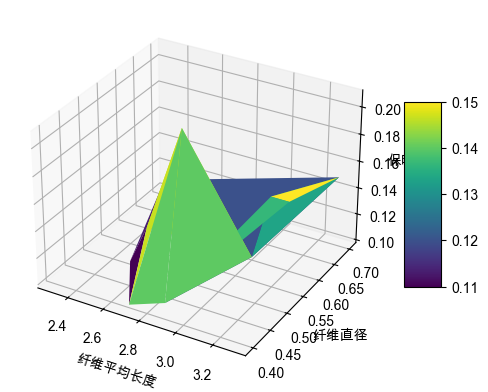

In [23]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# 数据
data = {
    '保暖能力': [0.1,0.1,0.1,0.11,0.15,0.13,0.11,0.15,0.21,0.15,0.15],
    '纤维平均长度': [2.5, 3.0, 2.7, 2.3, 3.2, 2.6, 2.9, 3.1, 2.8, 3.3],
    '纤维直径': [0.5, 0.6, 0.4, 0.7, 0.6, 0.5, 0.4, 0.6, 0.5, 0.7]
}

# 提取数据
x = data['纤维平均长度']
y = data['纤维直径']
z = data['保暖能力']

# 绘制3D surface图
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_trisurf(x, y, z, cmap='viridis')

# 添加颜色条
fig.colorbar(surf, shrink=0.5, aspect=5)

# 设置坐标轴标签
ax.set_xlabel('纤维平均长度')
ax.set_ylabel('纤维直径')
ax.set_zlabel('保暖能力')

plt.show()


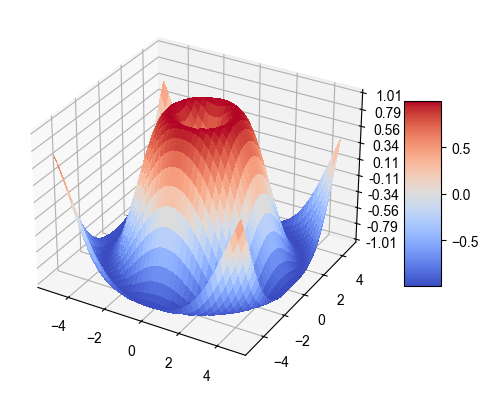

In [20]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

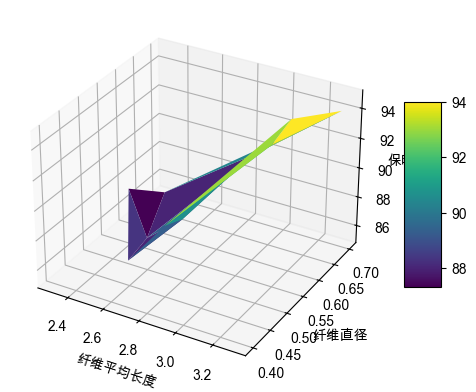

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# 数据
data = {
    '保暖能力': [90, 92, 88, 85, 95, 87, 91, 93, 89, 94],
    '纤维平均长度': [7,6,18,23,20,39,27,26,64,42,61],
    '纤维直径': [30,19,27,27,91,71,46,151,133,64]
}

# 提取数据
x = data['纤维平均长度']
y = data['纤维直径']
z = data['保暖能力']

# 绘制3D surface图
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_trisurf(x, y, z, cmap='viridis')

# 添加颜色条
fig.colorbar(surf, shrink=0.5, aspect=5)

# 设置坐标轴标签
ax.set_xlabel('纤维平均长度')
ax.set_ylabel('纤维直径')
ax.set_zlabel('保暖能力')

plt.show()


       carat        cut color clarity  depth  table  price     x     y     z
0       0.23      Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
1       0.21    Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
2       0.23       Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31
3       0.29    Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63
4       0.31       Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75
...      ...        ...   ...     ...    ...    ...    ...   ...   ...   ...
53935   0.72      Ideal     D     SI1   60.8   57.0   2757  5.75  5.76  3.50
53936   0.72       Good     D     SI1   63.1   55.0   2757  5.69  5.75  3.61
53937   0.70  Very Good     D     SI1   62.8   60.0   2757  5.66  5.68  3.56
53938   0.86    Premium     H     SI2   61.0   58.0   2757  6.15  6.12  3.74
53939   0.75      Ideal     D     SI2   62.2   55.0   2757  5.83  5.87  3.64

[53940 rows x 10 columns]


<Axes: xlabel='carat', ylabel='price'>

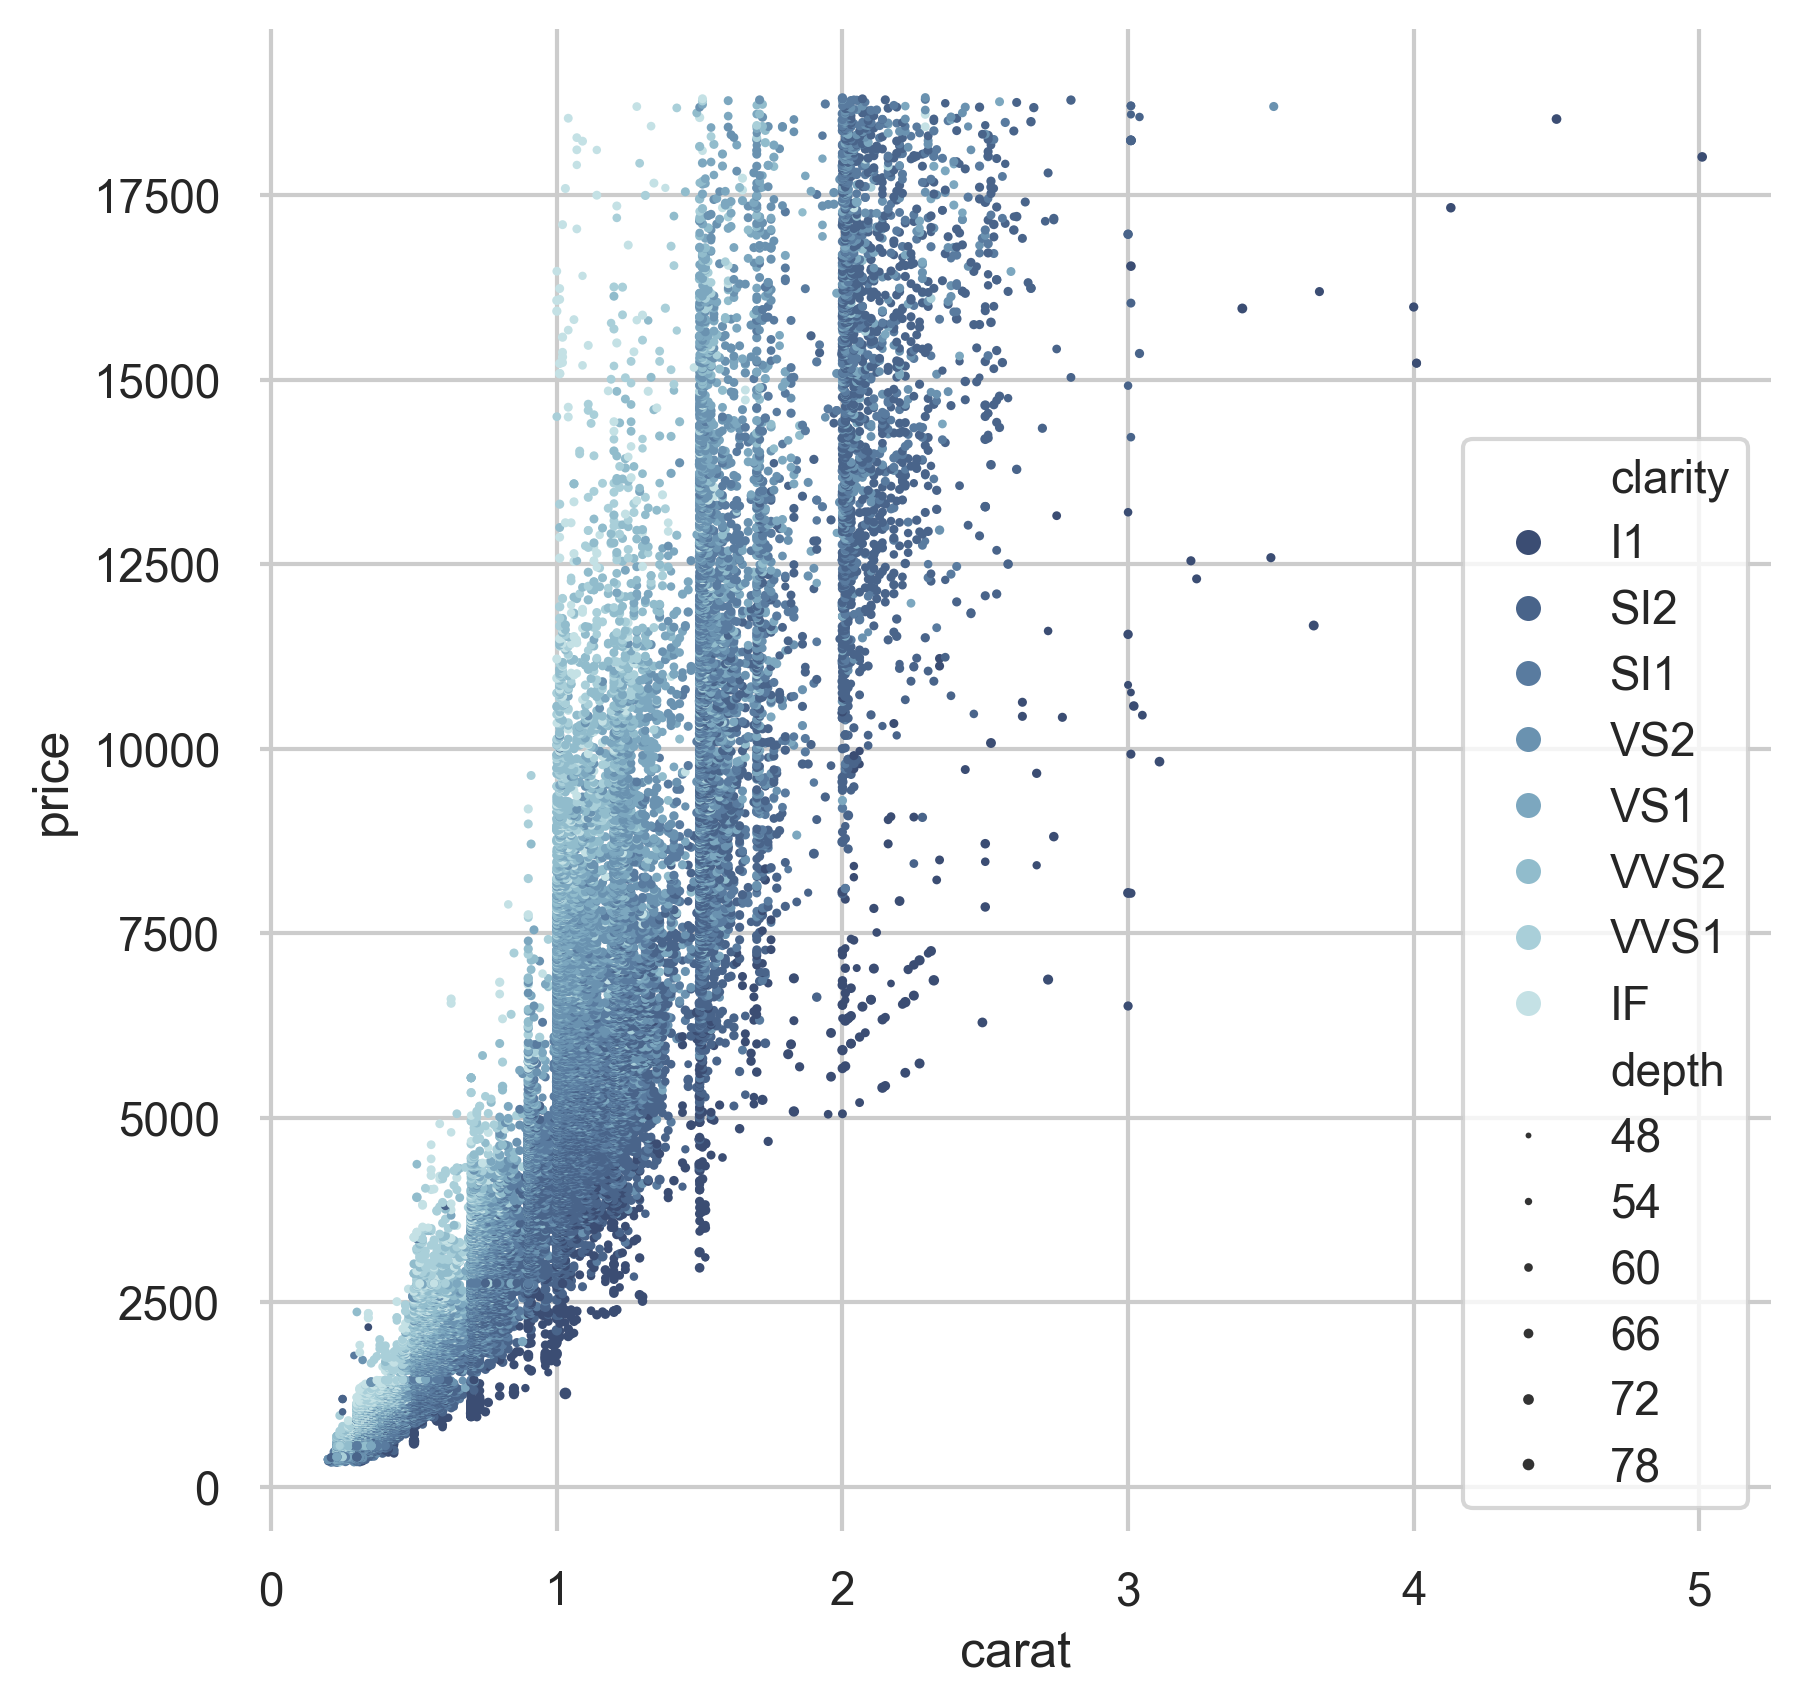

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint 
sns.set_theme(style="whitegrid")

plt.rcParams['figure.dpi'] = 300 #分辨率

# Load the example diamonds dataset
diamonds = sns.load_dataset("diamonds")
pprint(diamonds)
# help(sns.load_dataset)

# Draw a scatter plot while assigning point colors and sizes to different
# variables in the dataset
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
clarity_ranking = ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"]
sns.scatterplot(x="carat", y="price",
                hue="clarity", size="depth",
                palette="ch:r=-.2,d=.3_r",
                hue_order=clarity_ranking,
                sizes=(1, 8), linewidth=0,
                data=diamonds, ax=ax)

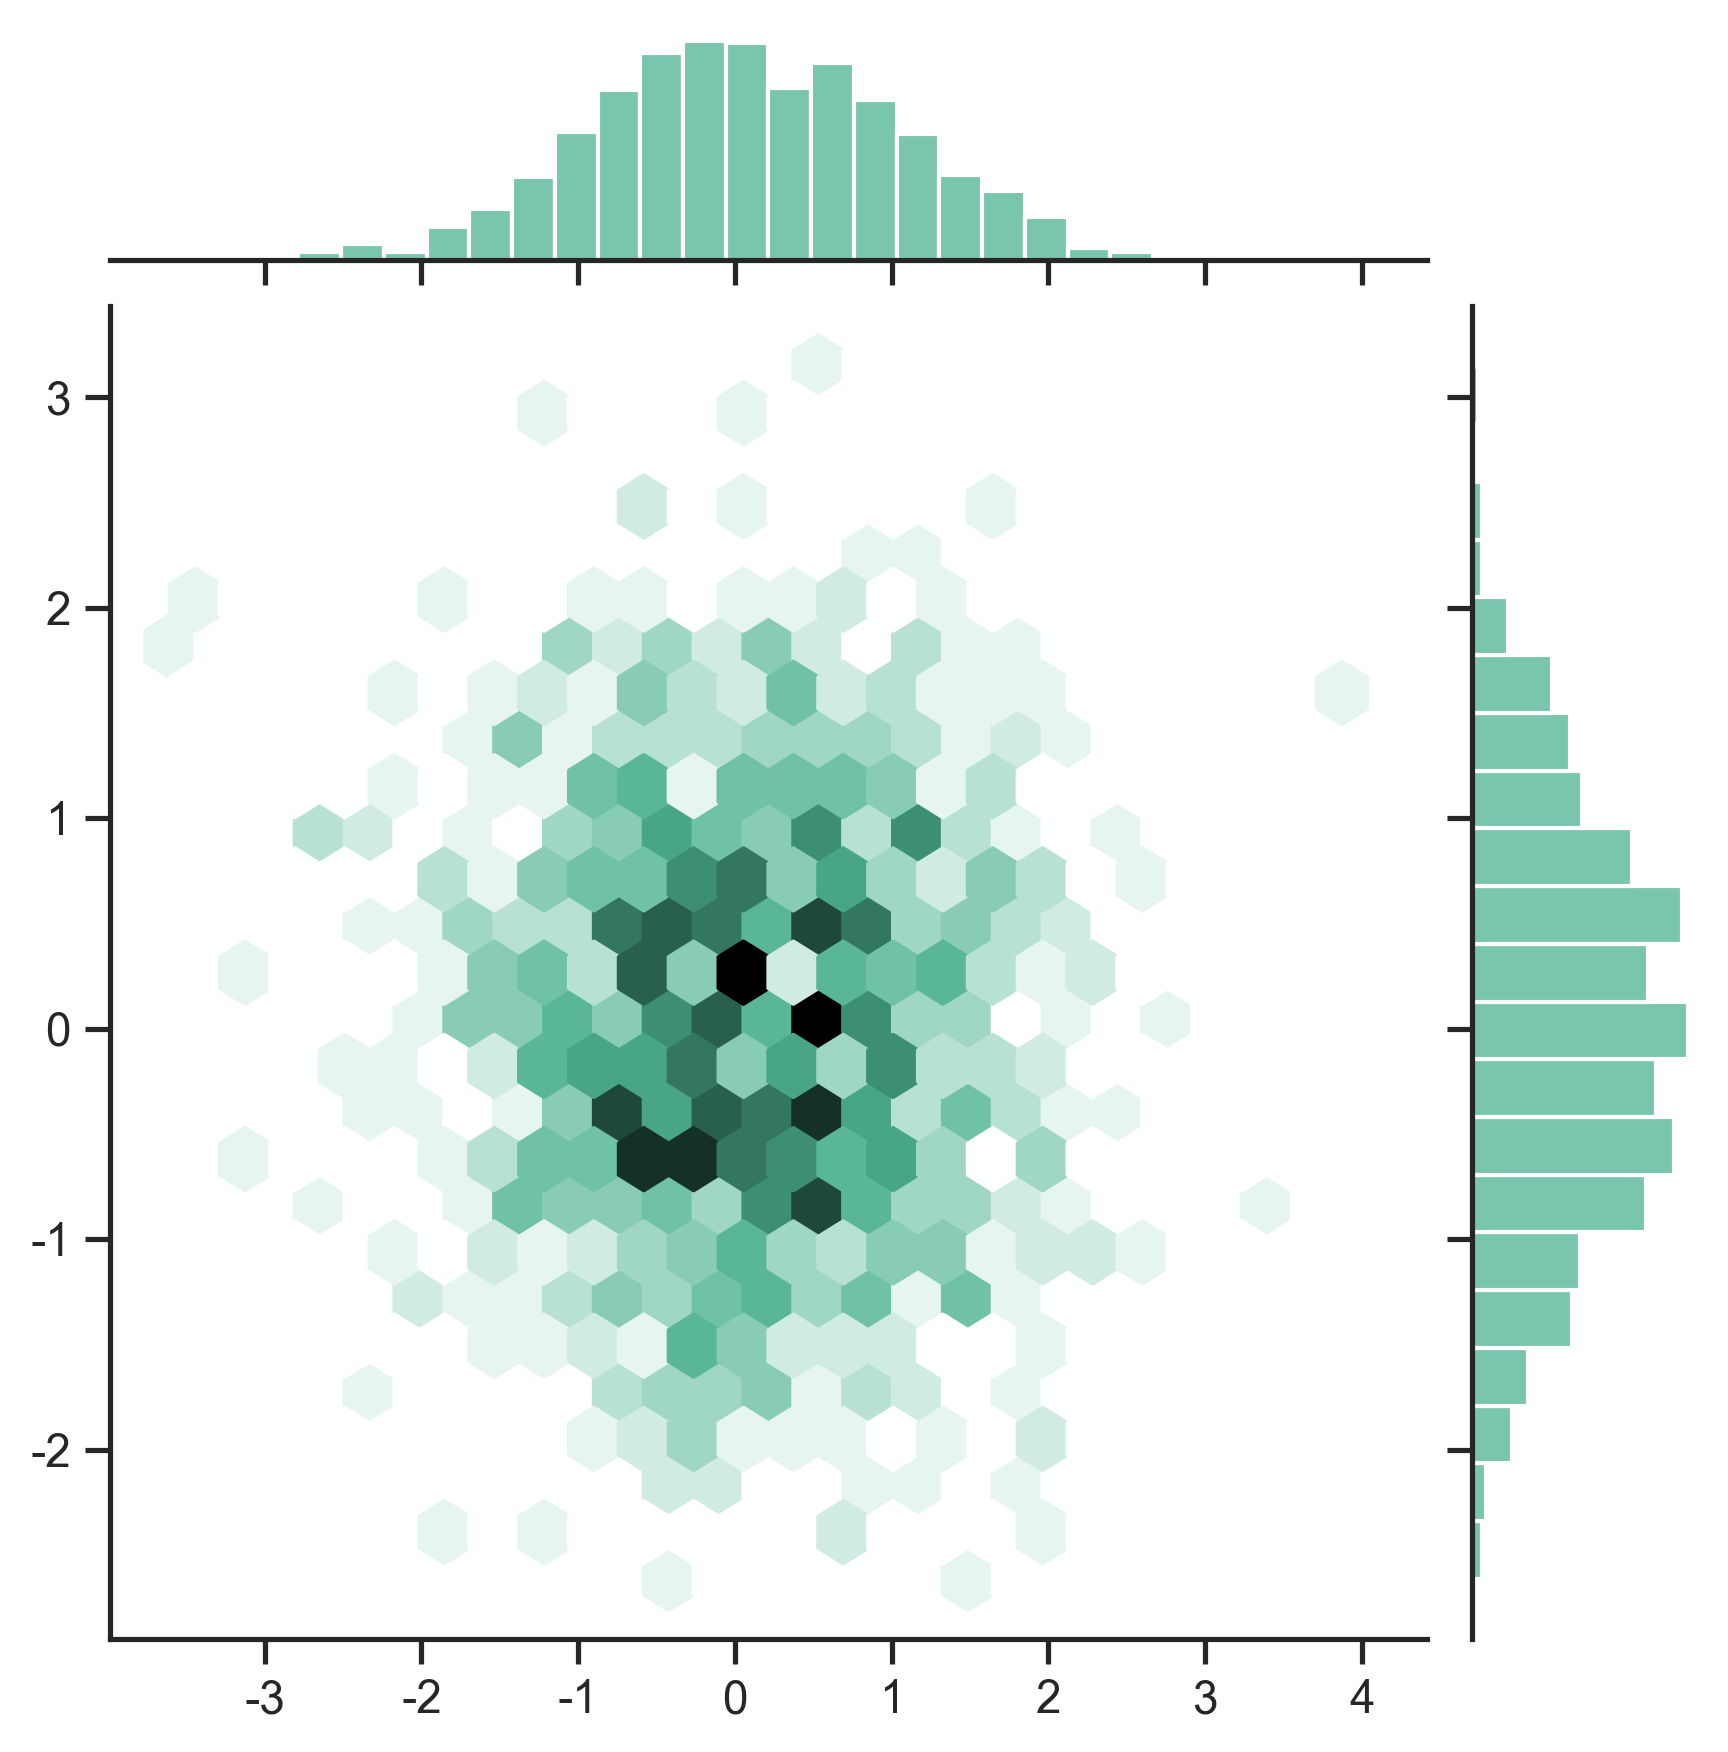

In [5]:
import numpy as np
import seaborn as sns
sns.set_theme(style="ticks")

rs = np.random.RandomState(11)
# Fixing random state for reproducibility
np.random.seed(19680801)

# the random data
x = np.random.randn(1000)
y = np.random.randn(1000)

sns.jointplot(x=x, y=y, kind="hex", color="#4CB391")

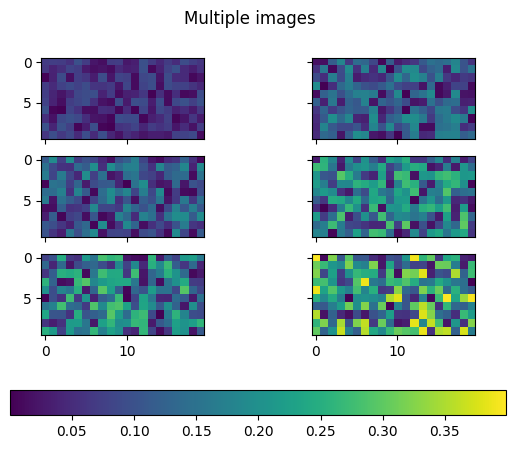

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import colors

np.random.seed(19680801)
Nr = 3
Nc = 2

fig, axs = plt.subplots(Nr, Nc)
fig.suptitle('Multiple images')

images = []
for i in range(Nr):
    for j in range(Nc):
        # Generate data with a range that varies from one plot to the next.
        data = ((1 + i + j) / 10) * np.random.rand(10, 20)
        images.append(axs[i, j].imshow(data))
        axs[i, j].label_outer()

# Find the min and max of all colors for use in setting the color scale.
vmin = min(image.get_array().min() for image in images)
vmax = max(image.get_array().max() for image in images)
norm = colors.Normalize(vmin=vmin, vmax=vmax)
for im in images:
    im.set_norm(norm)

fig.colorbar(images[0], ax=axs, orientation='horizontal', fraction=.1)


# Make images respond to changes in the norm of other images (e.g. via the
# "edit axis, curves and images parameters" GUI on Qt), but be careful not to
# recurse infinitely!
def update(changed_image):
    for im in images:
        if (changed_image.get_cmap() != im.get_cmap()
                or changed_image.get_clim() != im.get_clim()):
            im.set_cmap(changed_image.get_cmap())
            im.set_clim(changed_image.get_clim())


for im in images:
    im.callbacks.connect('changed', update)

plt.show()